## Questions for AIHUB

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

Consider these a list of questions that will allow you to prepare for the GEC Summer AI-Hub session (or to generally further your understanding of machine learning).  While we won't grade your answers to the questions we will provide solutions so that you can check your own understanding.  You will get the most reward if you look at the answers only after making a substantial effort to try to solve these questions on your own first.

<hr style="height:2pt">

![wine quality](https://ec.europa.eu/info/sites/info/files/food-farming-fisheries/news/images/istock-516799356.jpg)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>

### Overview 

From [Science Direct](https://www.sciencedirect.com/topics/food-science/wine-quality)

> Wine quality, as Maynard Amerine once said, is easier to detect than define. This is partially due to quality being primarily subjective, and strongly influenced by extrinsic factors. Correspondingly, defining wine quality in terms of its chemistry will never be more than partially successful. 
>
>Nonetheless, most serious wine connoisseurs tend to agree on what constitutes wine quality, that is, what they subjectively have come to like through extensive tasting. Although disappointingly nebulous, it has still been sufficient to guide grape growers and winemakers in their choice of the procedures they use. What is not certain is if this is a complex example of the blind leading the blind. 
>
>This disturbing thought is partially supported by the unquestioning acceptance of certain traditions concerning grape and wine production, notably ideas about small berries, old vines, limited yield, avoidance of irrigation, etc., as being critical to wine quality.

Assume that you are are hired by the renown wine magazine [Somm Journal](https://www.sommjournal.com/) to **help them predict quality of portuguese regional wines based upon a number of chemical attributes -- including density, acidity, alcohol content**.  Quality is an ordinal rank from 1 (worst) to 10 (best) of the variety of the wine as judged by three independent tasters. The final rank assigned is the median rank given by the tasters.

### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set can be obtained from the UCI Machine Learning Repository at the urls `http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv` and `http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv`. Each row in these file represents measurements of the chemical properties of a white or red wine variant of the Portuguese "Vinho Verde" wine. 

The 12 attributes are as follows:


-   `quality`
-   `fixed acidity`
-   `volatile acidity`
-   `citric acid`
-   `residual sugar`
-   `chlorides`
-   `free sulfur dioxide`
-   `total sulfur dioxide`
-   `density`
-   `pH`
-   `sulphates`
-   `alcohol`

Use `quality` as the response variable.

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1 [10pts]: Data Read-In, Cleaning and Preprocessing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the wine quality dataset from the csv files given in the UCI ML links into a pandas dataframe that you name `wine_data`.  Make sure to merge the data in the csvs into one data frame and add one additional binary feature called color that is 1 if the wine is red and 0 if it's white.

**1.2** Do the data types make sense?  Calculate the **Inter-Quartile Range (IQR)** for each feature.  The IQR can be calculated by subtracting the 25th percentile from the 75th percentile.  Let's call a data point an **upper outlier** for a particular feature if its value for that feature is > the mean of that feature + 1.5 * IQR.  Similarly a data point is a **lower outlier** for a feature if its value for that feature is < the mean of that feature - 1.5 * IQR.  Which features have outliers (upper or lower)?  Create a table showing how many upper and lower outliers there are for each feature.

**1.3** Split the updated `wine_data` dataset into a training set and test set. Use a `StandardScaler` from `sklearn.preprocessing` to standarize your data

In [3]:
#S 1.1
wine_data_red = pd.read_csv('/Users/mike/master/AI-HUB-ML-master/Data/winequality-red.csv', ';')
wine_data_white = pd.read_csv('/Users/mike/master/AI-HUB-ML-master/Data/winequality-white.csv', ';')

# mark the kind of the wine
wine_data_red['color'] = 1
wine_data_white['color'] = 0

# merge two dataframes
wine_data = pd.merge(wine_data_red, wine_data_white, how = 'outer')
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
2,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1


In [4]:
#S 1.2
# get the describe of the dataframe
wd_stat = wine_data.describe()

upper_outliers, lower_outliers = [], []
upper_num, lower_num = [], []

for idx, column in enumerate(wd_stat):
    if(column == 'quality' or column == 'color'):
        continue
    
    # caculate the value of the iqr
    iqr = wd_stat.iloc[6,idx] - wd_stat.iloc[4, idx]
    
    # > each time caculate the last dataframe's length
    high_limit = wd_stat.iloc[6, idx] + 1.5*iqr
    upper_outliers.append(wine_data.loc[wine_data[wine_data.columns[idx]] > high_limit])
    upper_num.append(len(upper_outliers[-1]))
    
    # < each time caculate the last dataframe's length
    low_limit = wd_stat.iloc[4, idx] - 1.5*iqr
    lower_outliers.append(wine_data.loc[wine_data[wine_data.columns[idx]] < low_limit])
    lower_num.append(len(lower_outliers[-1]))
    
# get columns of the wine_data
feature_columns = wine_data.columns[:11]

wine_upper_outliers = pd.DataFrame({'Feature': feature_columns,'Upper Outliers': upper_num})
wine_lower_outliers = pd.DataFrame({'Feature': feature_columns, 'Lower Outliers': lower_num})

wine_lower_outliers

,Feature,Lower Outliers
0,fixed acidity,7
1,volatile acidity,0
2,citric acid,279
3,residual sugar,0
4,chlorides,0
5,free sulfur dioxide,0
6,total sulfur dioxide,0
7,density,0
8,pH,7
9,sulphates,0


In [5]:
wine_upper_outliers

,Feature,Upper Outliers
0,fixed acidity,350
1,volatile acidity,377
2,citric acid,230
3,residual sugar,118
4,chlorides,286
5,free sulfur dioxide,62
6,total sulfur dioxide,10
7,density,3
8,pH,66
9,sulphates,191


In [37]:
# 1.3 Split the updated wine_data dataset into a training set and test set. Use a StandardScaler from sklearn.preprocessing to standarize your data
#Separate target from training features
X = wine_data.drop('quality', axis = 1)
y = wine_data.quality
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=150, 
                                                    stratify=y)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question, we continue validating the data, and begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Visualize the histograms of each of the features. pandas's `hist` or seaborn's `kdeplot` functionality may come in handy here.

**2.2** Use pandas' `scatter_matrix` to visualize the inter-dependencies among all predictors in the dataset. [Be aware that this may take quite some time to run.]

**2.3** Explore in more detail potential correlations amongst the different features by leveraging a pair-wise correlation matrix and depicting it as a heatmap.  What are some features have relatively high positive or negative correlations?

**2.4** We merged the datasets for white and red wines.  It may be instructive to determine how the two wine types differ along various features.  Plot side-by-side distributions of the red and white wines for wine quality.  What does your visualization say about how the two types of wine differ?

**2.5** Repeat your visualization from **2.4** for another feature you'd expect the two types of wines to differ based on your correlation plot in **2.3**.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1015a0b00>,
      dtype=object)

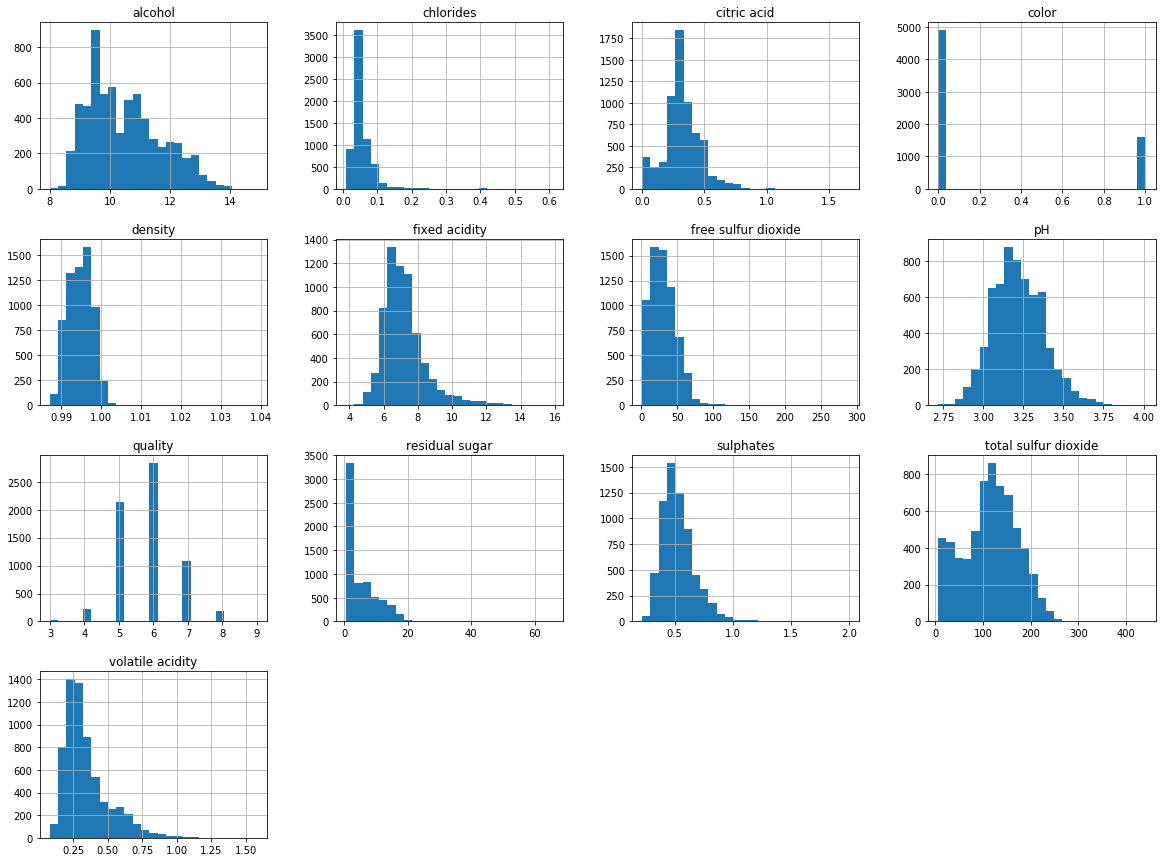

In [7]:
#2.1 
#直方图为hist, 密度图为kde
wine_data.hist(bins=25, figsize=(20,15)) 

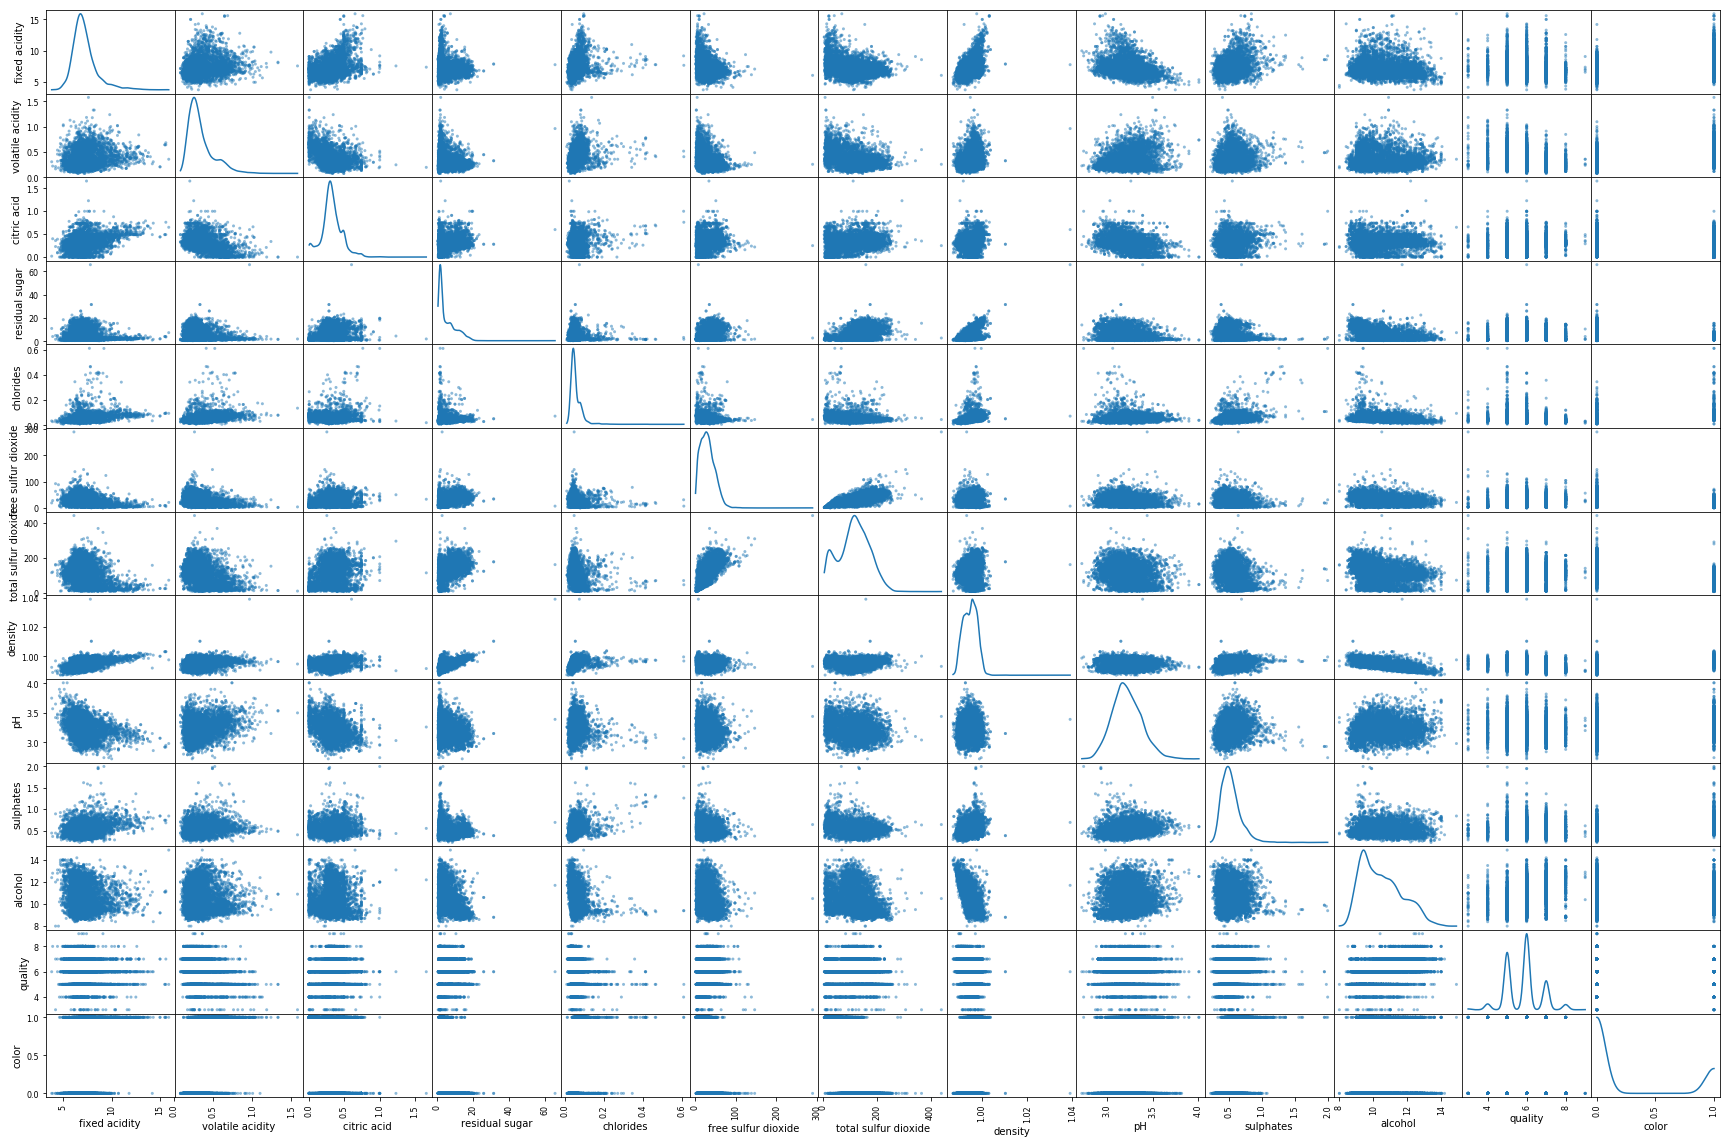

In [8]:
#2.2
# alpha 透明度 kde 密度图，range_padding图像在x轴，y轴原点附近留白，值越大，留白越多。
scatter_matrix(wine_data, figsize=(30,20), diagonal='kde', range_padding = 0.1); 

Text(114.0, 0.5, 'feature2')

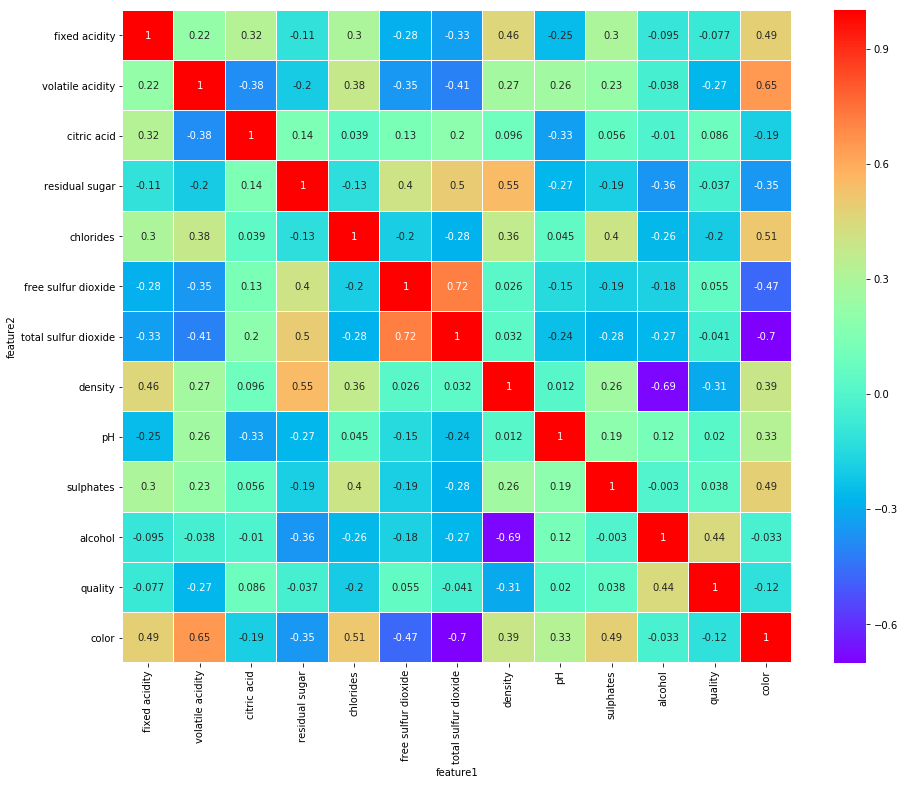

In [9]:
#2.3
f,ax=plt.subplots(figsize=(15, 12))
# get the correlations of wine_data
# line is white(default)
sns.heatmap(wine_data.corr(), annot = True, linewidths = 0.02, cmap = 'rainbow', ax = ax)
ax.set_xlabel("feature1")
ax.set_ylabel("feature2")

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


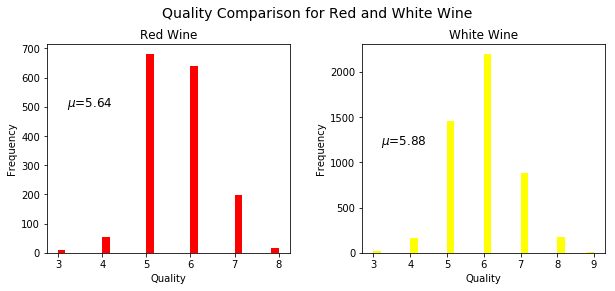

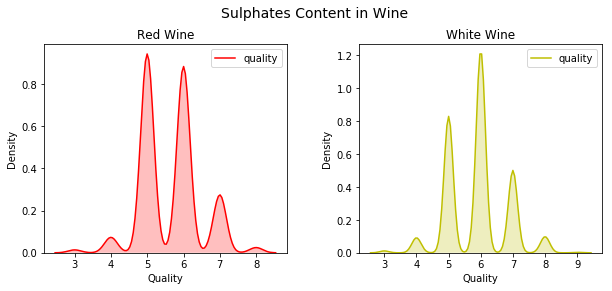

In [10]:
# 2-4

# I have no idea about this question

# facets with histograms
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("Quality Comparison for Red and White Wine", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Frequency") 
ax1.text(3.2, 500, r'$\mu$='+str(round(wine_data[wine_data['color'] == 1]['quality'].mean(),2)), fontsize=12)
ax1.hist(wine_data[wine_data['color'] == 1]['quality'], color='red', bins=30)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Frequency")
ax2.text(3.2, 1200, r'$\mu$='+str(round(wine_data[wine_data['color'] == 0]['quality'].mean(),2)), fontsize=12)
ax2.hist(wine_data[wine_data['color'] == 0]['quality'], color='yellow', bins=30)


# facets with density plots
fig = plt.figure(figsize = (10, 4))
title = fig.suptitle("Sulphates Content in Wine", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Density") 
sns.kdeplot(wine_data[wine_data['color'] == 1]['quality'], ax=ax1, shade=True, color='r')

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Density") 
sns.kdeplot(wine_data[wine_data['color'] == 0]['quality'], ax=ax2, shade=True, color='y');

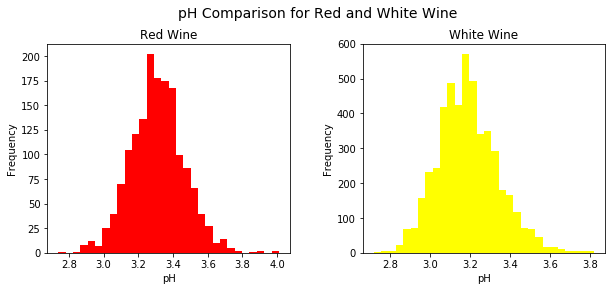

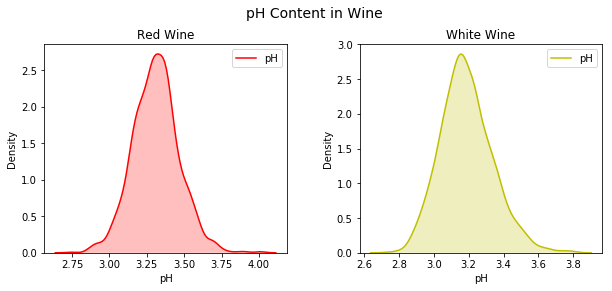

In [11]:
#2.5
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("pH Comparison for Red and White Wine", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("pH")
ax1.set_ylabel("Frequency")
ax1.hist(wine_data[wine_data['color'] == 1]['pH'], color='red', bins=30)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("pH")
ax2.set_ylabel("Frequency")
ax2.hist(wine_data[wine_data['color'] == 0]['pH'], color='yellow', bins=30)


# facets with density plots
fig = plt.figure(figsize = (10, 4))
title = fig.suptitle("pH Content in Wine", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("pH")
ax1.set_ylabel("Density") 
sns.kdeplot(wine_data[wine_data['color'] == 1]['pH'], ax=ax1, shade=True, color='r')

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("pH")
ax2.set_ylabel("Density") 
sns.kdeplot(wine_data[wine_data['color'] == 0]['pH'], ax=ax2, shade=True, color='y');

<div class='exercise'> <b> Question 3 [20pts]: Multiple Linear Regression </b> </div>

**3.1** Use `sklearn` to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `quality`.  Show the regression coefficients.

**3.2** Report the $R^2$ score for your multiple linear regression model on the training and test sets.

**3.3** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05).

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?


In [40]:
# 3.1
model = LinearRegression()
# X_train, y_train, = train_test_split(
#     wine_data, wine_data['quality']) 
model.fit(X_train, y_train)
model_coef = pd.DataFrame({"coefficients":model.coef_}, index = X.columns)
model_coef

,coefficients
fixed acidity,0.107414
volatile acidity,-1.487148
citric acid,-0.140168
residual sugar,0.058030
chlorides,-0.572966
free sulfur dioxide,0.005758
total sulfur dioxide,-0.000979
density,-98.541226
pH,0.492460
sulphates,0.690770


In [19]:
# 3.2
model_train_pred =  model.predict(X_train)
model_test_pred = model.predict(X_test)

print(r2_score(y_train ,model_train_pred))
print(r2_score(y_test, model_test_pred))

0.31168618253591773
0.2548763004190089


In [24]:
# 3.3
# 最小二乘法 OLS
# 为模型增加常数项，即回归线在 y 轴上的截距, y 为结果变量
X = sm.add_constant(X_train)
y = y_train
ols_model = OLS(y, X)
est = ols_model.fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     171.1
Date:                Sat, 13 Jul 2019   Prob (F-statistic):               0.00
Time:                        20:35:04   Log-Likelihood:                -4988.6
No. Observations:                4547   AIC:                         1.000e+04
Df Residuals:                    4534   BIC:                         1.009e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   98.6337     16.211      6.084      0.000      66.852     130.416
fixed acidity            0.1074      0.019      5.803      0.000       0.071       0.144
volatile acidity        -1.4871      0.096    -15.472      0.000      -1.676      -1.299
citric acid             -0.1402      0.095     -1.481      0.139      -0.326       0.045
residual sugar           0.0580      0.007      8.445      0.000       0.045       0.072
chlorides               -0.5730      0.415     -1.380      0.168      -1.387       0.241
free sulfur dioxide      0.0058      0.001      6.309      0.000       0.004       0.008
total sulfur dioxide    -0.0010      0.000     -2.555      0.011      -0.002      -0.000
density                -98.5412     16.480     -5.980      0.000    -130.849     -66.233
pH                       0.4925      0.106      4.628      0.000       0.284       0.701
sulphates                0.6908      0.090      7.672      0.000       0.514       0.867
alcohol                  0.2481      0.021     11.887      0.000       0.207       0.289
color                    0.3357      0.066      5.054      0.000       0.205       0.466
==============================================================================
Omnibus:                      101.223   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.410
Skew:                           0.027   Prob(JB):                     1.13e-49
Kurtosis:                       4.089   Cond. No.                     2.87e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
est.params[(est.pvalues < 0.05) ]

const                   98.633693
fixed acidity            0.107414
volatile acidity        -1.487148
residual sugar           0.058030
free sulfur dioxide      0.005758
total sulfur dioxide    -0.000979
density                -98.541226
pH                       0.492460
sulphates                0.690770
alcohol                  0.248123
color                    0.335685
dtype: float64

In [26]:
est.params[(est.pvalues >= 0.05) ]

citric acid   -0.140168
chlorides     -0.572966
dtype: float64

<div class='exercise'><b> Question 4 [20pts]: K-Nearest Neighbor Regression </b> </div>

Let's use a different type of regression model -- K-Nearest Neighbor Regression -- and see how well that fits the data.


**4.1** Use 5-fold cross validation to find the best `n_neighbors` parameter for the `sklearn KNeighborRegressor`.  Select `n_neighbors` from {1, 10, 75, 250, 500, 750, 1000}.  Plot the $R^2$ score vs the number of neighbors.  Which `n_neighbors` was the best value?

**4.2** Fit your chosen model from **4.1** to the training data. Report the $R^2$ score for your K-Nearest Neighbor model on the training and test sets.


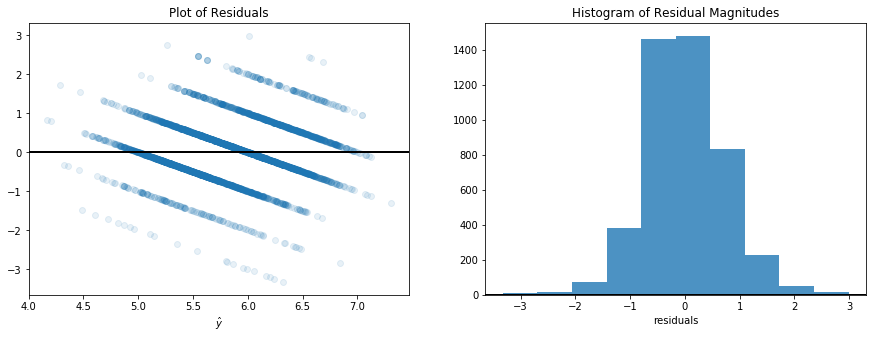

In [27]:
# 3.4
residuals = y_train - model_train_pred
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(model_train_pred, residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')

axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()

In [28]:
# 4.1
knn_gs_params = {'n_neighbors': [1, 5, 10, 15, 25, 50, 75]}
knn_model_gs = GridSearchCV(KNeighborsRegressor(), knn_gs_params, cv=5, scoring='r2', return_train_score=True)

knn_model_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 5, 10, 15, 25, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [29]:
knn_model_gs.best_params_

{'n_neighbors': 15}

In [30]:
knn_gs_results = pd.DataFrame(knn_model_gs.cv_results_)
knn_gs_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003796,0.002823,0.004706,0.000639,1,{'n_neighbors': 1},-0.080691,-0.206028,-0.100471,-0.125024,...,-0.151770,0.063790,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.002510,0.000140,0.005527,0.000223,5,{'n_neighbors': 5},0.141647,0.091929,0.132208,0.169932,...,0.117639,0.041055,4,0.433859,0.438606,0.423660,0.420308,0.438254,0.430937,0.007574
2,0.002478,0.000065,0.055577,0.098338,10,{'n_neighbors': 10},0.168309,0.126743,0.171308,0.196980,...,0.151426,0.036563,2,0.307293,0.324156,0.308588,0.307239,0.321055,0.313666,0.007380
3,0.002401,0.000104,0.007397,0.000209,15,{'n_neighbors': 15},0.180375,0.130884,0.180861,0.179757,...,0.151964,0.037302,1,0.254058,0.275842,0.257339,0.259847,0.269155,0.263248,0.008055
4,0.002457,0.000060,0.009088,0.000506,25,{'n_neighbors': 25},0.157234,0.121626,0.158863,0.170466,...,0.138542,0.031574,3,0.199304,0.221259,0.203468,0.201944,0.215036,0.208202,0.008461
5,0.002518,0.000029,0.012285,0.000148,50,{'n_neighbors': 50},0.131672,0.102171,0.136804,0.137621,...,0.116768,0.024363,5,0.154050,0.164749,0.153413,0.147598,0.169126,0.157787,0.007924
6,0.002470,0.000098,0.015735,0.000209,75,{'n_neighbors': 75},0.123674,0.097755,0.122279,0.122455,...,0.107762,0.020064,6,0.132024,0.141693,0.132170,0.128326,0.145825,0.136007,0.006608


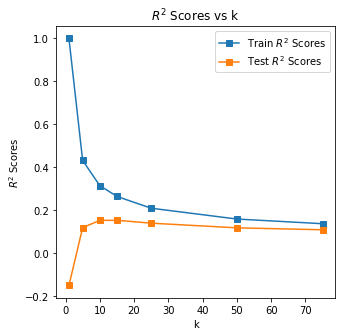

In [31]:
# GridSerachCV cv_reasults_ 是计算结果

fig, axes = plt.subplots(figsize = (5,5))
axes.plot(knn_gs_results['param_n_neighbors'], knn_gs_results['mean_train_score'], 's-', label='Train $R^2$ Scores')
axes.plot(knn_gs_results['param_n_neighbors'], knn_gs_results['mean_test_score'], 's-', label='Test $R^2$ Scores')
axes.set_xlabel('k')
axes.set_ylabel('$R^2$ Scores')
# A generic title of this format (y vs x) is generally appropriate
axes.set_title("$R^2$ Scores vs k")
# Including a legend is very important
axes.legend();

In [32]:
# 4.2
knn_model_best = KNeighborsRegressor(n_neighbors=15)

knn_model_best.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=15, p=2,
          weights='uniform')

In [33]:
knn_train_pred = knn_model_best.predict(X_train)
knn_test_pred = knn_model_best.predict(X_test) 

# calculating and reporting the requested values, particularly the Test R^2
print('Train R^2 = {:.4}'.format(r2_score(y_train, knn_train_pred)))
print('Test R^2 = {:.4}'.format(r2_score(y_test, knn_test_pred)))

Train R^2 = 0.2782
Test R^2 = 0.1506


<div class='exercise'><b> Question 5 [20pts]: Comparing Ridge, Lasso, and OLS </b> </div>

**5.1** Use `sklearn` to fit multiple linear regression models with regularization  to the training set using all the predictors (no interactions or polynomial terms) to predict `quality`.  Make sure to fit a Ridge model and a Lasso model. Use `RidgeCV` and `LassoCV` with 5-fold cross-validation to select the best regularization level from among `(.1,.5,1,5,10,50,100)`.  Show the coefficients for each model.

**5.2** What are the $R^2$ scores for Lasso, Ridge, and OLS?  How do they compare?

**5.3** Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.4** What trends do you see in the plot above?

In [34]:
# 5.1
alphas = (.1,.5,1,5,10,50,100)

ridge_regressor = RidgeCV(cv=5, alphas=alphas).fit(X_train, y_train)
lasso_regressor = LassoCV(cv=5, alphas=alphas).fit(X_train, y_train)

In [41]:
# displaying coefficients of each feature
ols_coefficients = pd.DataFrame('OLS Coefficient':model.coef_, X.columns)
#ols_coefficients.columns = ['OLS Coefficient'] 

ols_coefficients

,OLS Coefficient
fixed acidity,0.107414
volatile acidity,-1.487148
citric acid,-0.140168
residual sugar,0.058030
chlorides,-0.572966
free sulfur dioxide,0.005758
total sulfur dioxide,-0.000979
density,-98.541226
pH,0.492460
sulphates,0.690770


In [49]:
# 5.2
ols_train_pred = model.predict(X_train)
ols_test_pred = model.predict(X_test) 

ridge_train_pred = ridge_regressor.predict(X_train)
ridge_test_pred = ridge_regressor.predict(X_test)

lasso_train_pred = lasso_regressor.predict(X_train)
lasso_test_pred = lasso_regressor.predict(X_test) 

# calculating and reporting the requested values, particularly the Test R^2
print('OLS Train R^2 = {:.4}'.format(r2_score(y_train, ols_train_pred)))
print('OLS Test R^2 = {:.4}'.format(r2_score(y_test, ols_test_pred)))
print('OLS Test R^2 = ', round(r2_score(y_test, ols_test_pred), 4))

print('Ridge Train R^2 = {:.4}'.format(r2_score(y_train, ridge_train_pred)))
print('Ridge Test R^2 = {:.4}'.format(r2_score(y_test, ridge_test_pred)))

print('Lasso Train R^2 = {:.4}'.format(r2_score(y_train, lasso_train_pred)))
print('Lasso Test R^2 = {:.4}'.format(r2_score(y_test, lasso_test_pred)))

OLS Train R^2 = 0.3117
OLS Test R^2 = 0.2549
OLS Test R^2 =  0.2549
Ridge Train R^2 = 0.3065
Ridge Test R^2 = 0.2489
Lasso Train R^2 = 0.2307
Lasso Test R^2 = 0.1814


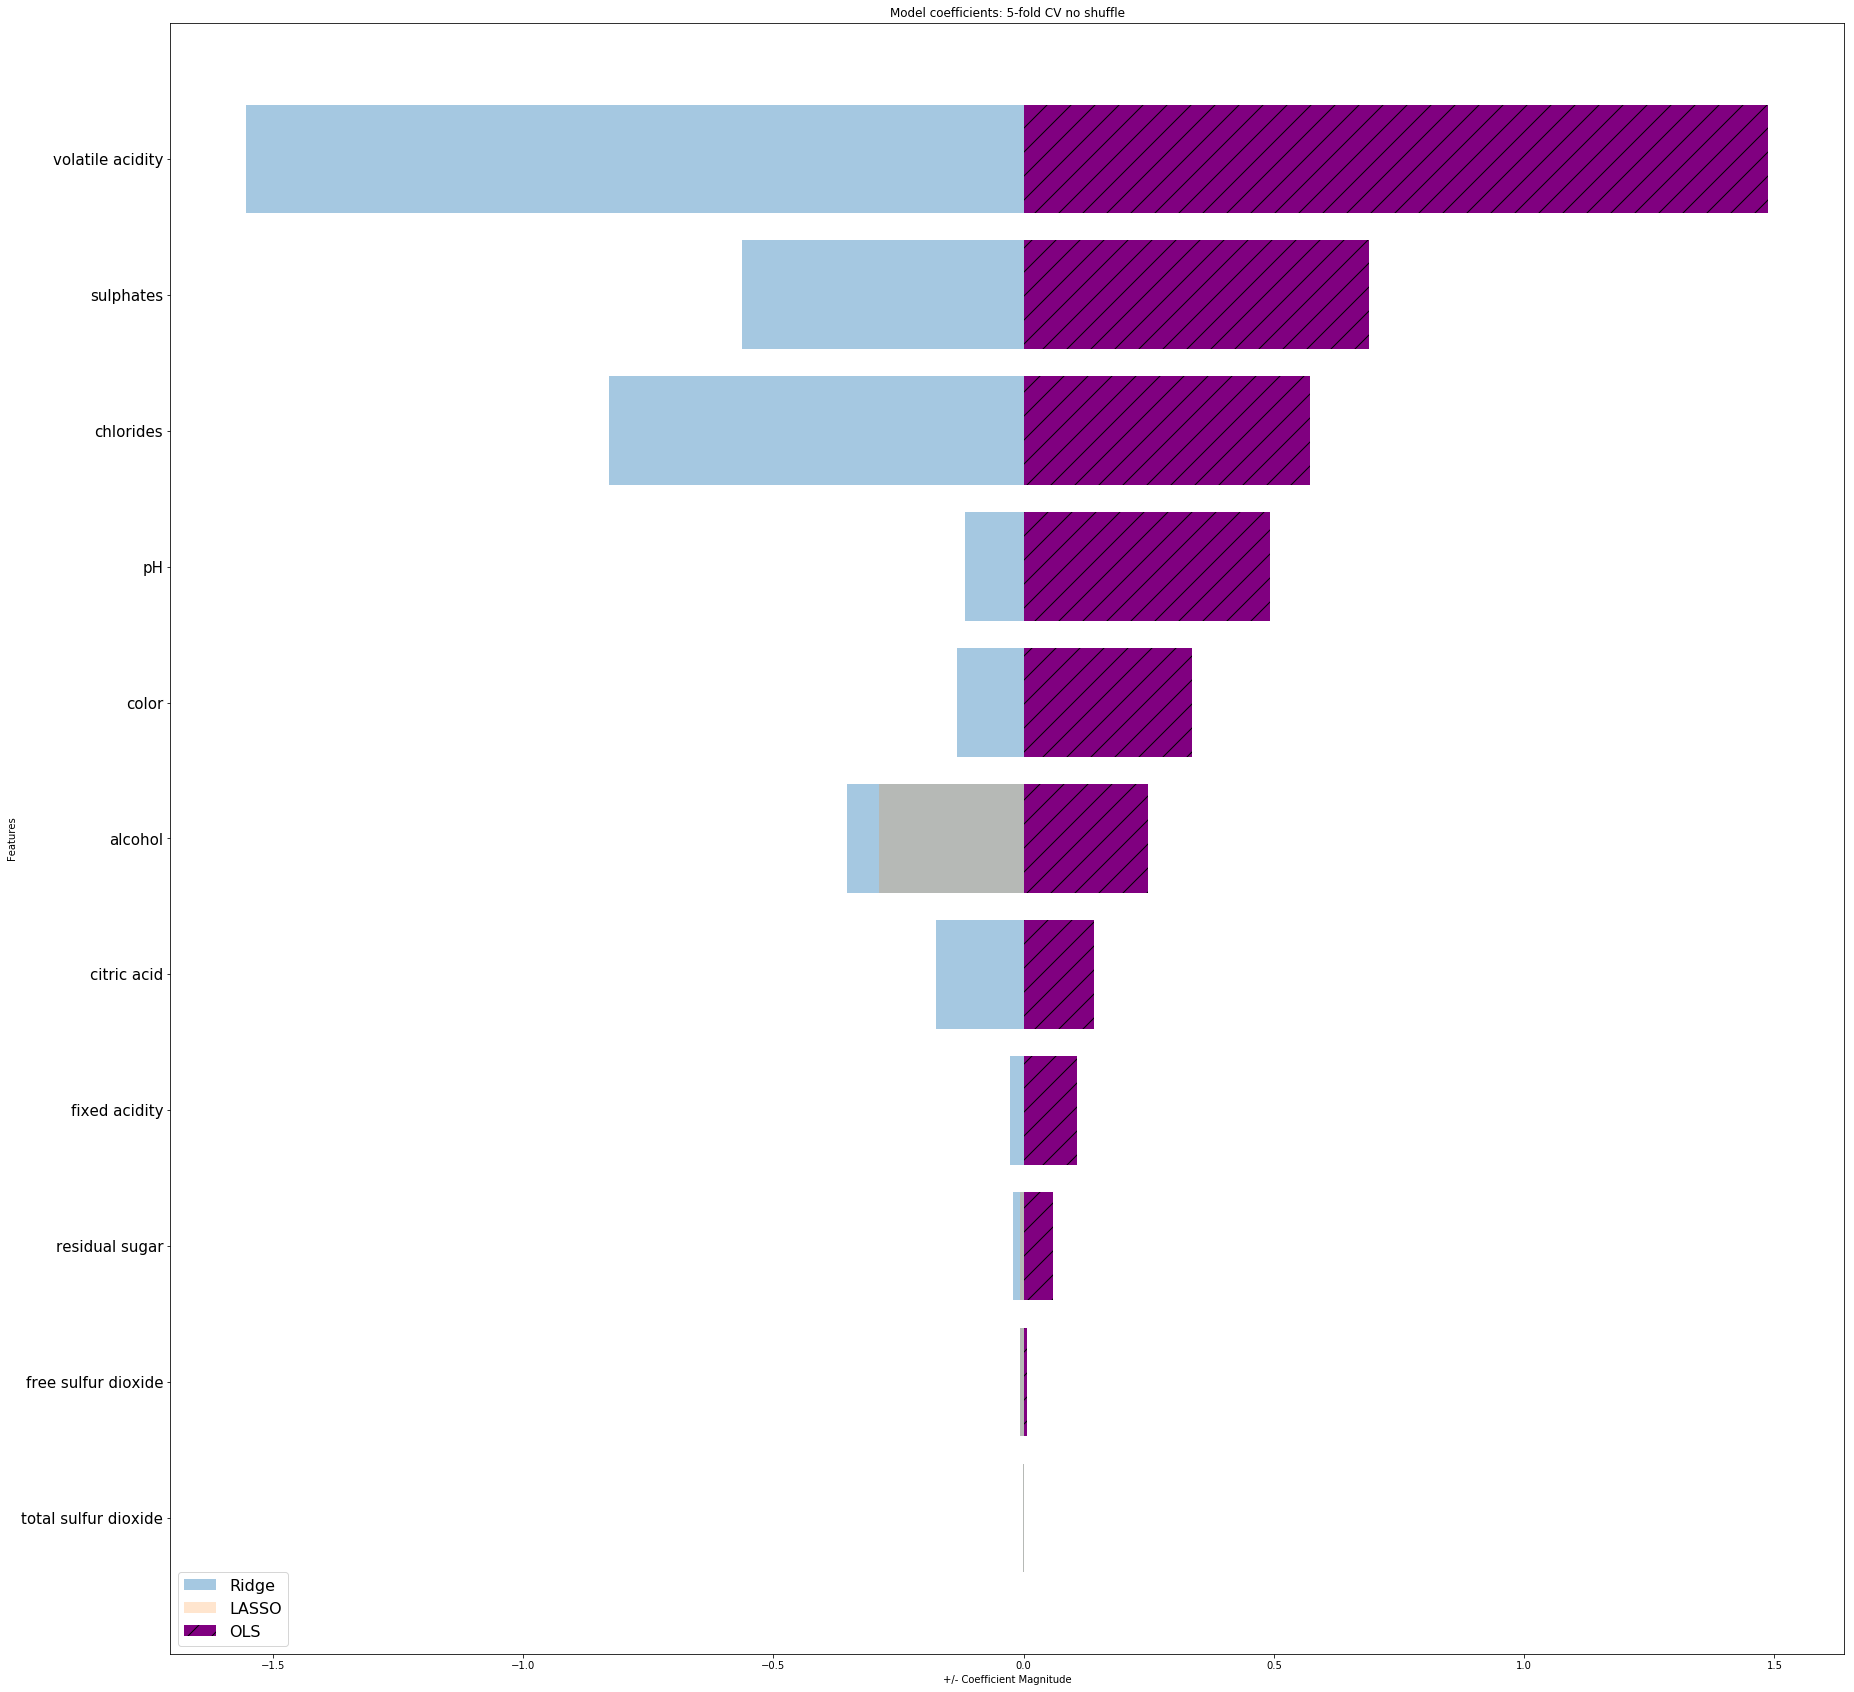

In [46]:
# 5.3
feature_names = X_train.columns.values

Ridge_coefficients = ridge_regressor.coef_
Lasso_coefficients = lasso_regressor.coef_
OLS_coefficients = model.coef_

si= np.argsort(np.abs(model.coef_))[:-1]
feature_names = X_train.columns.values[si]
n_coeffs = len(feature_names)

plt.figure(figsize=(30,30))
plt.barh(np.arange(n_coeffs), 
         -np.abs(Ridge_coefficients)[si], 
         alpha=0.4, label='Ridge')

plt.barh(np.arange(n_coeffs), 
         -np.abs(Lasso_coefficients)[si], 
         alpha=0.2, label='LASSO')
plt.barh(np.arange(n_coeffs), 
         np.abs(OLS_coefficients)[si], 
         color='purple', hatch='/', label='OLS')

plt.yticks(range(n_coeffs), feature_names, rotation=0, fontsize=15)
plt.ylim(-1,n_coeffs)
#plt.xlim(-100,300)

plt.legend(fontsize=16)

plt.title("Model coefficients: 5-fold CV no shuffle")
plt.ylabel("Features")
plt.xlabel("+/- Coefficient Magnitude");

<div class='exercise'><b> Question 6 [20pts]: Polynomial Features </b> </div>

**6.1** Augment your training set by using the continuous features from `X_train` -- that is all the features except for `wine_color` to generate up to the fourth degree polynomial features (including interaction terms) and adding them to the datasets.  Call this new dataset  `X_train_poly`.

**6.2** Repeat the process in **5.1** to create a test set `X_test_poly` also augmented with polynomial features up to the fourth degree.

**6.3** Use `sklearn` to fit multiple linear regression models with and withoutregularization to the augmented training set with polynomial feautres to predict `quality`.  Make sure to fit a simple OLS model, a Ridge model and a Lasso model. Use `RidgeCV` and `LassoCV` with 5-fold cross-validation to select the best regularization level from among `(.1,.5,1,5,10,50,100)`.  Show the coefficients for each model.

Note: On the lasso model, you may need to increase `max_iter` to 100,000 for the optimization to converge.

**6.4** What are the training and test set $R^2$ scores for Lasso, Ridge, and OLS on the augmented data sets?  How do they compare to your earlier models on the original data set?

**6.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**6.6** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial?